# Dynamic SSSP SC'18 Figures

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns     # you can install this with "pip install seaborn"
import sys
import pprint, math
import glob
from pylab import MaxNLocator
%matplotlib inline  
#print(plt.rcParams.keys())
params = {'font.size': 18, 'figure.titlesize':'medium','legend.fontsize': 'medium','legend.handlelength':1,
          'lines.linewidth':2, 'lines.markersize':12, 'legend.handletextpad':0.2,'axes.formatter.useoffset':False,}
plt.rcParams.update(params)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
sns.set_style("whitegrid")   
#print('Baseline power',baseline_power)

## Settings
Edit the variables below to indicate which plots to generate, the algs list is a list of subdirectories with log files containing time, power, and energy measurements.

In [2]:
whats = {'Energy':'Total CPU Energy (J)','Power':'Average CPU Power (W)', 'Memory':'Total Memory (GB)','Time':'Time (seconds)'}
whats = {'Memory':'Total Memory (GB)','Time':'Time (seconds)'}
resultsdir = 'output-8epv-new/'
epvs = ['8']
nws = ['ER','G']
insperc = ['100','75']
speedup = False
printData = True

## Misc stuff
whats = {
        'Total Time for Creating tree' : 'SSSP Create Tree',
        'Total Time for Initial Update' : 'SSSP Initial Update',
        'Total Time for Complete Update':'SSSP Complete Update',
        'TotalTime' : 'Galois'}

seq_time = {}

## Functions
A couple of functions that extract the data and generate the plots.

In [3]:
def processGaloisLine(line):
    path,contents = line.strip().split(':')
    d,fname = path.split('/')
    experiment = fname.split('.')[0]
    parts = experiment.split('-')[-1].split('_')
    network = '_'.join(parts[:-1])
    threads = parts[-1].strip('t')
    network = '_'.join(experiment.split('-')[-1].split('_')[:-1])
    return experiment,network,threads,contents

def processSSSPLine(path,line):
    contents = line
    d,fname = path.split('/')
    experiment = fname.split('.')[0]
    parts = experiment.split('-')[-1].split('_')
    network = '_'.join(parts[:-1])
    threads = parts[-1].strip('t')
    network = '_'.join(experiment.split('-')[-1].split('_')[:-1])
    parts2 = contents.split()
    time = float(parts2[-1])
    memory = 0
    what = whats[' '.join(parts2[:-1])]
 
    return experiment,network,threads,what,time,memory

def parseTimeData():
    global seq_time
    # Galois: times-galois.txt (divide time by 1000 to get seconds)
    # output-8epv/galois-248_G_75i_1000000_4t.log:STAT,(NULL),TotalTime,4,18838,18838,0,0,0
    # SSSP: times-sssp.txt
    # output-8epv/sssp-248_G_75i_1000000_32t.log:Total Time for Complete Update 34.470351
    
    galois_time = {}; sssp_time = {}
    lines = open(resultsdir+'times-galois.txt').readlines()
    for l in lines:
        experiment,network,threads,contents = processGaloisLine(l)
        parts = contents.split(',')
        time = float(parts[4])/1000 # seconds
        exp = network+'-'+threads
        if not exp in galois_time.keys(): galois_time[exp] = []
        galois_time[exp].append(time)
        
    files = glob.glob(resultsdir+'sssp*.log')
    seq_time = {}
    for f in files:
        lines = open(f,'r').readlines()
        tmptotals = {}; totals = {}
        skip = True; localtimes = []
        for l in lines:
            if l.startswith('==Update Starts ======='): 
                skip = False; counter = 0
            if not skip and l.find('Time')>=0: 
                experiment,network,threads,what,time,memory = processSSSPLine(f,l)
                exp = network+'-'+threads
                
                if not exp in sssp_time.keys(): sssp_time[exp] = []
                if not l.startswith('Total Time for Creating tree'):
                    sssp_time[exp].append((what,time))
                    localtimes.append(time)
                if len(localtimes) == 2: 
                    total = sum(localtimes)
                    sssp_time[exp].append(('SSSP Total',total))
                    if not network in seq_time: seq_time[network] = []
                    if threads == '1': seq_time[network].append(total)
            if l.find('Exit status:') >=0: 
                skip = True; localtimes = []

    return galois_time,sssp_time
        

## Galois comparison plots
All the data structures are populated by the functions above

In [4]:
galois_time, sssp_time = parseTimeData()
columns=['Experiment','Threads','Time (sec.)','Algorithm']
df = pd.DataFrame(columns=columns)
nets = []
for k in sorted(galois_time.keys()):
    net,th = k.split('-')
    for i in range(0,len(galois_time[k])):
        tmpdf = pd.DataFrame([[net,int(th),galois_time[k][i],'Galois']],columns=columns)
        df = df.append(tmpdf, ignore_index=True).fillna(0)
    for i in range(0,len(sssp_time[k])):
        tmpdf = pd.DataFrame([[net,int(th),sssp_time[k][i][1],sssp_time[k][i][0]]],columns=columns)
        df = df.append(tmpdf, ignore_index=True).fillna(0)
    if not net in nets: nets.append(net)
#df.loc[df['Experiment']=='248_ER_100i_1000000']

In [33]:
#Improvement over Galois:
def s(x): return '%s' % 'RMAT24_'+'_'.join(x.split('_')[1:-1])
def f(x): return '%1.1f' % x
def i(x): return '%d' % x
#fig, ax = plt.subplots();   fig.set_size_inches(8,6)
for net in nets:
    print(net)
    #print("Seq time",net,seq_time[net])
    df2 = df.loc[df['Experiment']==net]
    dfg = df2.loc[df2['Algorithm']=='Galois'].drop(['Algorithm'],axis=1).rename(columns={'Time (sec.)':'Galois'})
    dfs = df2.loc[df2['Algorithm']=='SSSP Total'].drop(['Algorithm'],axis=1).rename(columns={'Time (sec.)':'SSSP Update'})
    df3 = pd.merge(dfg,dfs, on=['Experiment', 'Threads'])
    df3['Improvement'] = df3['Galois'] / df3['SSSP Update']
    groupedvalues=df3.groupby(['Experiment','Threads']).mean().reset_index()
    print(groupedvalues.to_latex(columns=['Experiment','Threads','Galois','SSSP Update','Improvement'],
                                 index=False, formatters=[s,i,f,f,f]))

    #dfs['Speedup'] = dfg['Time (sec.)']/dfs['Time (sec.)'])
    #avgseqtime = sum(seq_time[net])/len(seq_time[net])
    #df2['Ideal'] = avgseqtime / df2.loc[df2['Algorithm']=='SSSP Total']['Time (sec.)']
    #df2['Speedup'] = df2.loc[df2['Algorithm']=='SSSP Total']['Time (sec.)'] / avgseqtime


248_ER_100i_1000000
\begin{tabular}{lrrrr}
\toprule
     Experiment & Threads & Galois & SSSP Update & Improvement \\
\midrule
 RMAT24\_ER\_100i &       1 &   53.5 &        25.5 &         2.1 \\
 RMAT24\_ER\_100i &       2 &   27.2 &        16.5 &         1.6 \\
 RMAT24\_ER\_100i &       4 &   14.4 &         8.8 &         1.6 \\
 RMAT24\_ER\_100i &       8 &    7.8 &         4.9 &         1.6 \\
 RMAT24\_ER\_100i &      16 &    4.6 &         3.1 &         1.5 \\
 RMAT24\_ER\_100i &      32 &    3.0 &         2.5 &         1.2 \\
 RMAT24\_ER\_100i &      48 &    3.0 &         2.4 &         1.2 \\
 RMAT24\_ER\_100i &      64 &    2.8 &         2.4 &         1.2 \\
 RMAT24\_ER\_100i &      72 &    2.9 &         2.5 &         1.1 \\
\bottomrule
\end{tabular}

248_ER_75i_1000000
\begin{tabular}{lrrrr}
\toprule
    Experiment & Threads & Galois & SSSP Update & Improvement \\
\midrule
 RMAT24\_ER\_75i &       1 &   45.4 &        19.6 &         2.3 \\
 RMAT24\_ER\_75i &       2 &   24.7 &     

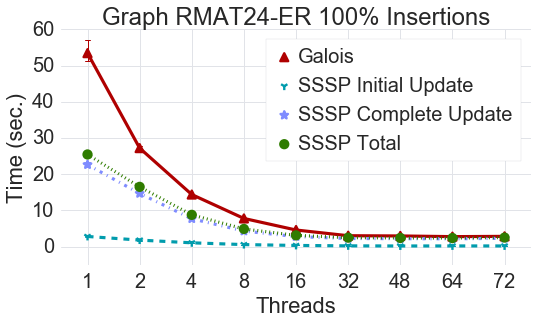

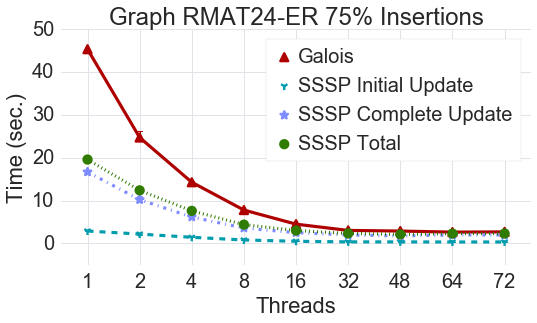

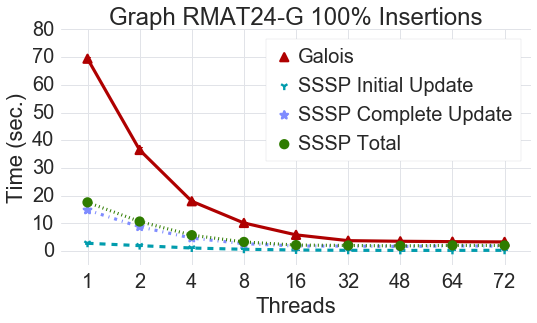

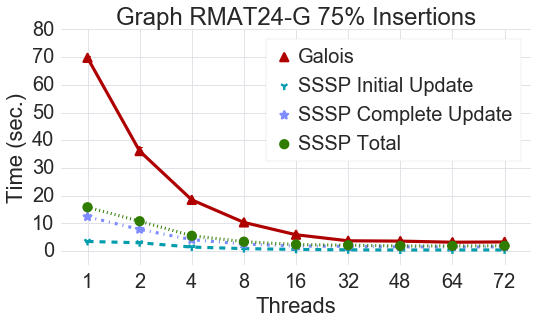

In [32]:
#print(df)
# Process data for plotting
colors = ['#af0000','#019cad','#7f8cff','#2f7c00','#5566fc']
sns.set(font_scale=2)
for net in nets:
    df2 = df.loc[df['Experiment']==net].copy(deep=True)
    df2['Threads'] = df2['Threads'].astype('int', copy=False)
    fig, ax = plt.subplots();   fig.set_size_inches(8,5)
    sns.set_palette(sns.color_palette(colors))
    g1 = sns.pointplot(x='Threads',y='Time (sec.)',data=df2,hue='Algorithm', errwidth=1, capsize=0.1,
                      markers=['^', '1','*','o','.'], #,'+','2','p','d','s','.'], 
                      linestyles=["-", "--", "-.",':','-'])
    g1.set_ylim(-5)
    g1.set(axis_bgcolor='white'); 
    legend = plt.legend(frameon=True); frame = legend.get_frame(); frame.set_facecolor('white'); frame.set_edgecolor('#cbcfd6')
    ax.grid(color='#e1e3e8', linestyle='-', linewidth=1)
    parts = net.split('_')
    titlestr = 'Graph RMAT24' + '-' + parts[1] + " %s%% Insertions" % parts[2].strip('i')
    plt.title(titlestr)
    plt.tight_layout()
    plt.savefig(net + "_Time.pdf")
    #g2 = sns.pointplot(x='Threads',y='Ideal',data=df3,color='black',markers=['.'],linestyles=['--'],legend=None)
sns.set_style("whitegrid") 

## Scaling

The data for these plots is in the RMAT.csv and Real.csv files, which must be in the same directory as this notebook.

In [27]:
df3 = pd.read_csv('RMAT.csv',skip_blank_lines=True).dropna()
df4 = pd.melt(df3, id_vars=["Graph", "Insertion %"], var_name='Threads',
                  value_vars = ['1','2','4','8','16','32','64'],value_name="Time (sec.)")
df4['Threads'] = df4['Threads'].astype('int', copy=False)
df4['Insertion %'] = df4['Insertion %'].astype('int', copy=False)
df4.head()

,Graph,Insertion %,Threads,Time (sec.)
0,RMAT24-G,100,1,157.394629
1,RMAT24-G,75,1,89.158096
2,RMAT24-G,50,1,151.558773
3,RMAT24-G,100,1,157.246909
4,RMAT24-G,75,1,88.176373


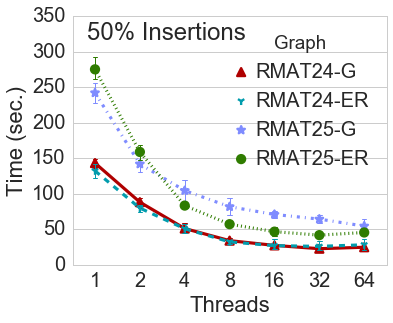

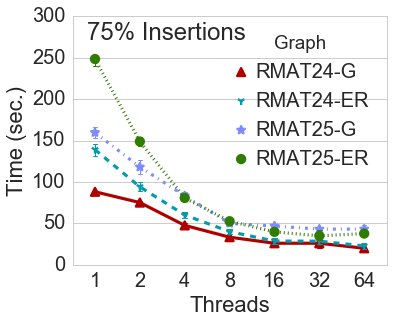

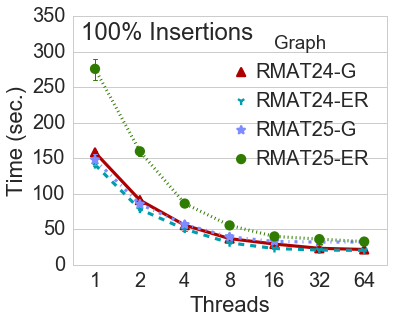

In [29]:
for ins in [50,75,100]:
    fig, ax = plt.subplots();   fig.set_size_inches(6,5)
    g1 = sns.pointplot(x='Threads',y='Time (sec.)',data=df4.loc[df4['Insertion %']==ins],
                       hue='Graph', errwidth=1, capsize=0.1,
                        markers=['^', '1','*','o','.'], #,'+','2','p','d','s','.'], 
                        linestyles=["-", "--", "-.",':','-'])
    g1.text(.3, .98, '%d%% Insertions'%ins, horizontalalignment='center',verticalalignment='top',transform=g1.transAxes)

    #g1 = sns.factorplot(x="Threads", y="Time (sec.)", hue="Graph", data=df4.loc[df4['Insertion %']==ins],
    #               size=6, kind="bar", palette="bright", legend_out=False)
    #plt.suptitle('%d%% Insertions'%ins, x=.45, y=0.92)
    plt.tight_layout()
    plt.savefig("Scaling-RMAT-%d.pdf" % ins)

          Graph  Insertion %  Threads  Time (sec.)
0  Live Journal          100        1    69.858921
1  Live Journal           75        1   128.790545
2  Live Journal           50        1   139.354813
3  Live Journal          100        1    72.149324
4  Live Journal           75        1   123.393463


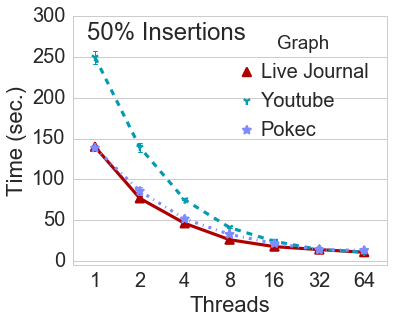

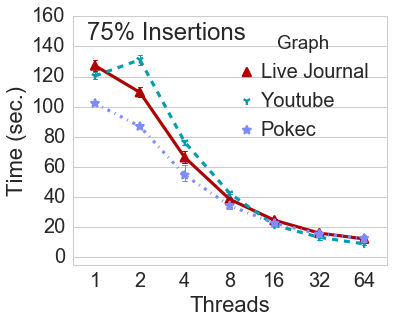

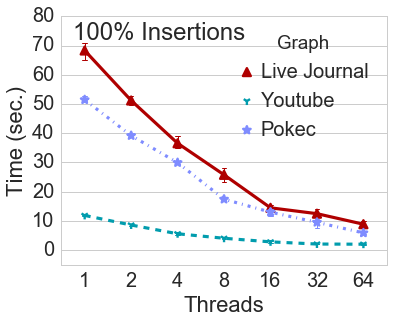

In [31]:
df5 = pd.read_csv('Real.csv',skip_blank_lines=True).dropna()
df6 = pd.melt(df5, id_vars=["Graph", "Insertion %"], var_name='Threads',
                  value_vars = ['1','2','4','8','16','32','64'],value_name="Time (sec.)")
df6['Threads'] = df6['Threads'].astype('int', copy=False)
print(df6.head())
for ins in [50,75,100]:
    fig, ax = plt.subplots();   fig.set_size_inches(6,5)
    g1 = sns.pointplot(x='Threads',y='Time (sec.)',data=df6.loc[df4['Insertion %']==ins],
                       hue='Graph', errwidth=1, capsize=0.1,
                      markers=['^', '1','*','o','.'], #,'+','2','p','d','s','.'], 
                      linestyles=["-", "--", "-.",':','-'])
    g1.set_ylim(bottom=-5)
    g1.text(.3, .98, '%d%% Insertions'%ins,horizontalalignment='center',verticalalignment='top',transform=g1.transAxes)

    #g1 = sns.factorplot(x="Threads", y="Time (sec.)", hue="Graph", data=df6.loc[df4['Insertion %']==ins],
    #                   size=6, kind="bar", palette="bright", legend_out=False)
    #plt.suptitle('%d%% Insertions'%ins, x=.45, y=0.92)
    plt.tight_layout()
    plt.savefig("Scaling-Real-%d.pdf" % ins)

          Graph  Insertion %  Threads  Time (sec.)
0       RMAT24e          100        1   320.842489
1       RMAT24e          100        1   261.421520
2  Live Journal          100        1    23.327276
3  Live Journal          100        1    37.291425
4       RMAT24e          100        2   185.620628


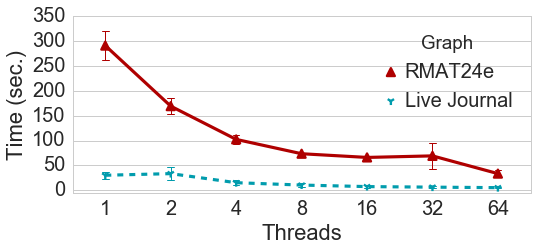

In [10]:
ddf = pd.read_csv('DifferentSource.csv',skip_blank_lines=True).dropna()
dd = pd.melt(ddf, id_vars=["Graph", "Insertion %"], var_name='Threads',
             value_vars = ['1','2','4','8','16','32','64'],value_name="Time (sec.)")
dd['Threads'] = dd['Threads'].astype('int', copy=False)
print(dd.head())
fig, ax = plt.subplots();   fig.set_size_inches(8,4)
g = sns.pointplot(x='Threads',y='Time (sec.)',data=dd, hue='Graph', errwidth=1, capsize=0.1,
                  markers=['^', '1','*','o','.'], #,'+','2','p','d','s','.'], 
                  linestyles=["-", "--", "-.",':','-'])
g.set_ylim(-5)
plt.tight_layout()
plt.savefig("DiffSource.pdf")

## Distributed-memory SSSPInc algorithm results
The data for these results is in the SSSPInc.csv file in the same directory as this notebook.

        Graph Algorithm  Update Size          What       Value
0  Friendster   SSSPInc      1000000   Time (sec.)    4294.991
1  Friendster   SSSPInc      1000000    Supersteps      14.000
2  Friendster   SSSPInc      1000000  Max Messages  155667.000
3  Friendster  SSSPBase      1000000   Time (sec.)    9060.578
4  Friendster  SSSPBase      1000000    Supersteps      19.000
         Graph Algorithm  Update Size         What  Time (sec.)
0   Friendster   SSSPInc      1000000  Time (sec.)     4294.991
3   Friendster  SSSPBase      1000000  Time (sec.)     9060.578
6   Friendster   SSSPInc     10000000  Time (sec.)     4582.659
9   Friendster  SSSPBase     10000000  Time (sec.)     5891.165
12  Friendster   SSSPInc     20000000  Time (sec.)     4551.527


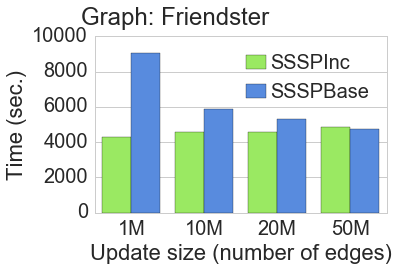

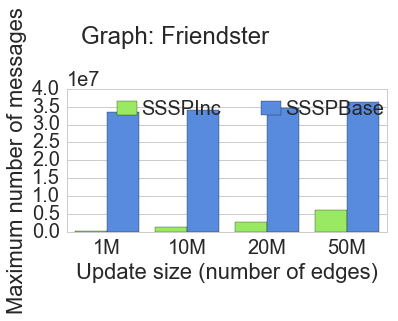

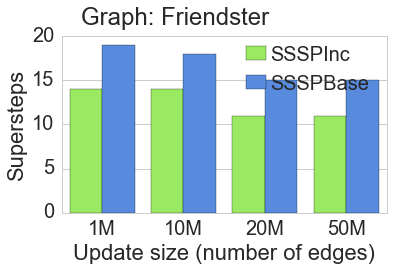

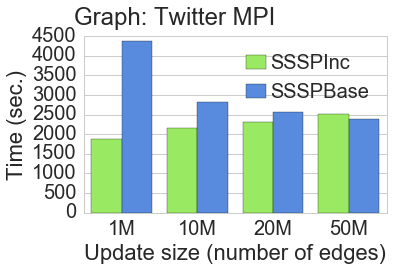

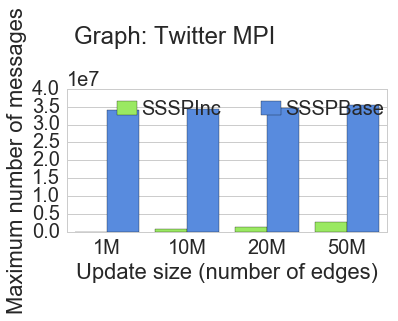

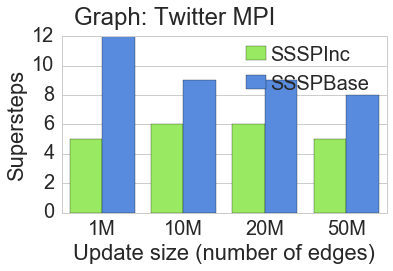

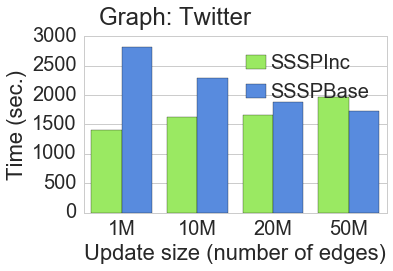

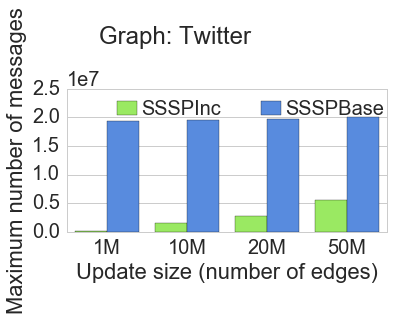

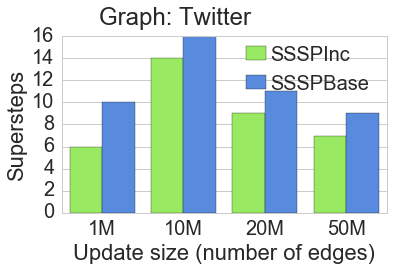

In [11]:
df7 = pd.read_csv('SSSPInc.csv',skip_blank_lines=True).dropna()
print(df7.head())
df7['Update Size'] = df7['Update Size'].astype('int', copy=False)
df7_time = df7.loc[df7['What']=='Time (sec.)'].rename(columns={'Value':'Time (sec.)'})
print(df7_time.head())
df7_msg = df7.loc[df7['What']=='Max Messages'].rename(columns={'Value':'Max Messages'})
df7_steps = df7.loc[df7['What']=='Supersteps'].rename(columns={'Value':'Supersteps'})
for net in ['Friendster','Twitter MPI','Twitter']:
    ## Time
    fig, ax = plt.subplots();   fig.set_size_inches(6,4)
    g1 = sns.barplot(x="Update Size", y="Time (sec.)", hue="Algorithm", data=df7_time[df7_time['Graph']==net],
                     ci=None, palette=sns.color_palette(['#96ff4c','#4286f4']))
    #g1.set_xticklabels(rotation=30)
    plt.suptitle('Graph: %s'% net, x=.45, y=.98)
    plt.legend(loc='upper right', ncol = 1, labelspacing=0.5)
    g1.set_xticklabels(['1M','10M','20M','50M'])
    g1.set_xlabel('Update size (number of edges)')
    plt.tight_layout(); 
    plt.savefig("SSSPInc-Time-%s.pdf" % net)
    
    # Maximum number of messages
    fig, ax = plt.subplots();   fig.set_size_inches(6,4)
    g2 = sns.barplot(x="Update Size", y="Max Messages", hue="Algorithm", data=df7_msg[df7_msg['Graph']==net], 
                        ci=None, palette=sns.color_palette(['#96ff4c','#4286f4']))
    plt.suptitle('Graph: %s'% net, x=.45, y=.98)
    g2.set_xticklabels(['1M','10M','20M','50M'])
    g2.set_ylabel('Maximum number of messages')
    g2.set_xlabel('Update size (number of edges)')
    plt.legend(loc='upper left', ncol = 2, labelspacing=0.5, bbox_to_anchor=(0.1, 1.05))
    plt.tight_layout(); 
    plt.savefig("SSSPInc-MaxMsgs-%s.pdf" % net)
    
    # Supersteps
    fig, ax = plt.subplots();   fig.set_size_inches(6,4)
    g3 = sns.barplot(x="Update Size", y="Supersteps", hue="Algorithm", data=df7_steps[df7_steps['Graph']==net], 
                     ci=None, palette=sns.color_palette(['#96ff4c','#4286f4']))
    plt.suptitle('Graph: %s'% net, x=.45, y=.98)
    plt.legend(loc='upper right', ncol = 1, labelspacing=0.5, bbox_to_anchor=(1, 1.05))
    g3.set_xticklabels(['1M','10M','20M','50M'])
    g3.set_xlabel('Update size (number of edges)')
    plt.tight_layout(); 
    plt.savefig("SSSPInc-Supersteps-%s.pdf" % net)